# Creating Contrast Curves

This notebook performs an analysis of contrast in PSF-Subtracted images. This process is done in a few simple steps:   

1) Fake planets are injected into the given dataset.  

2) pyKLIP is used to subtract the PSF of the star in the data.  

3) The fake planets are retrieved, and their post-klip flux values are measured.  

4) Contrast curves are created.

In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pyklip.klip
import pyklip.instruments.Instrument as Instrument
import pyklip.parallelized as parallelized
import pyklip.rdi as rdi
import pyklip.fakes as fakes

### Loading the dataset

In [14]:
#Import the dataset to be used
filtername = "f300m"

# read in roll 1
with fits.open("old_simulated_data/NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
    roll1_cube = hdulist[0].data

# read in roll 2
with fits.open("old_simulated_data/NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
    roll2_cube = hdulist[0].data  

# combine the two rows
full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

# two rolls are offset 10 degrees
pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

# for each image, the (x,y) center where the star is is just the center of the image
centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

# give it some names, just in case we want to refer to them
filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                      ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

#Define dataset
dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
dataset.flipx = False

### Reading in and centering the unocculted psf

In [16]:
# read in unocculted PSF
with fits.open("old_simulated_data/NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
    psf_cube = hdulist[0].data 
    print(psf_cube.shape)   
    
# collapse reference psf in time
psf_frame = np.nanmean(psf_cube, axis=0)

# find the centroid
bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=3, guessfwhm=2, guesspeak=1, refinefit=True)

psf_xcen, psf_ycen = bestfit[2:4]
print(psf_xcen, psf_ycen)

# recenter PSF to that location
x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
x += psf_xcen
y += psf_ycen

psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])
print(psf_stamp.shape)

#Need to uncollapse the reference psf.  
psf_stamp = np.expand_dims(psf_stamp, axis=0)
print(psf_stamp.shape)

(6, 101, 101)
70.45855749153525 29.8360856033007
(41, 41)
(1, 41, 41)


### Specifying the parameters of the fake planet/s to be injected

In [17]:
#Specify the desired contrasts of the fake planets' flux
input_contrasts = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
planet_seps = [15,20,25,30,35,40]
planet_fwhm = 3.5


#Defining angle of injected fakes in CCW angle from +x axis to +y axis
thetas = [np.ones(12)*30.0, np.ones(12)*60.0, np.ones(12)*90.0, np.ones(12)*150.0, np.ones(12)*180.0, np.ones(12)*210.0]
thetas = thetas+dataset.PAs
thetas

array([[ 30.,  30.,  30.,  30.,  30.,  30.,  40.,  40.,  40.,  40.,  40.,
         40.],
       [ 60.,  60.,  60.,  60.,  60.,  60.,  70.,  70.,  70.,  70.,  70.,
         70.],
       [ 90.,  90.,  90.,  90.,  90.,  90., 100., 100., 100., 100., 100.,
        100.],
       [150., 150., 150., 150., 150., 150., 160., 160., 160., 160., 160.,
        160.],
       [180., 180., 180., 180., 180., 180., 190., 190., 190., 190., 190.,
        190.],
       [210., 210., 210., 210., 210., 210., 220., 220., 220., 220., 220.,
        220.]])

## Inject the fake planets

In [18]:
for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas):
#Multiply unocculted psf by desired contrast level to simulate planet psf
    planet_fluxes = psf_stamp*input_contrast

    fakes.inject_planet(frames = dataset.input, 
                        centers=dataset.centers, 
                        inputflux=planet_fluxes, 
                        astr_hdrs=dataset.wcs, 
                        radius=planet_sep,
                        pa = None,
                        thetas = theta)

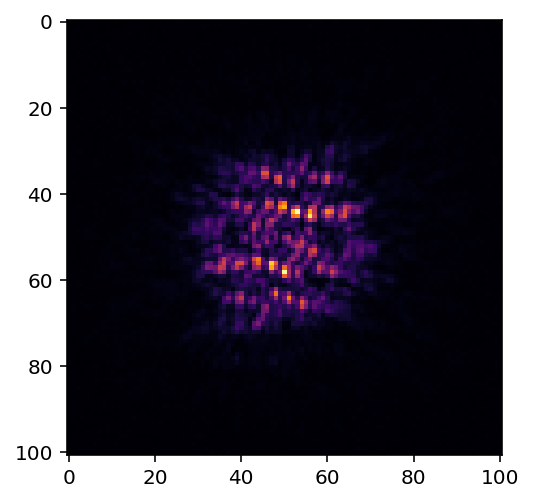

In [19]:
#Image with fakes injected before KLIP
plt.imshow(dataset.input[2], cmap = 'inferno')

## Run pyKLIP on injected fakes

In [20]:
#Set output directory
outputdir = 'contrastcurves'
fileprefix = 'FAKE_KLIP_ADI_A9K5S4M1'
numbasis = [1,5,10,20,50]


#Run KLIP on dataset with injected fakes
parallelized.klip_dataset(dataset, 
                          outputdir=outputdir, 
                          fileprefix=fileprefix, 
                          algo = 'klip', 
                          annuli=9, 
                          subsections=4, 
                          movement=1, 
                          numbasis=numbasis, 
                          mode="ADI")

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 36
27.78% done (9/36 completed)
55.56% done (19/36 completed)
83.33% done (29/36 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /Users/samuelsetegne/JWST-ERS-Pipeline/notebooks/contrastcurves


/Users/samuelsetegne/pyklip/pyklip/parallelized.py:1561: RuntimeWarning: Mean of empty slice
  KLmode_cube = np.nanmean(pixel_weights * dataset.output, axis=(1,2))


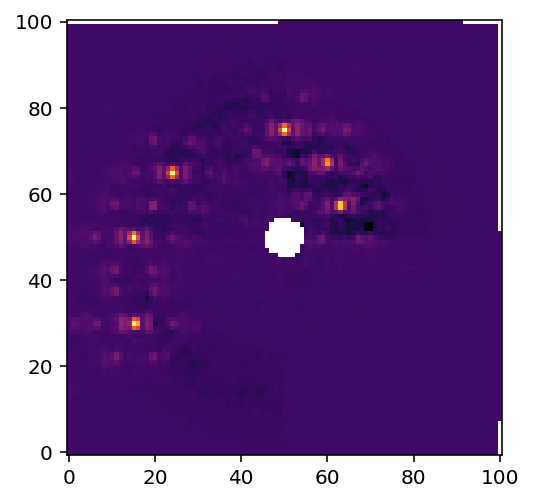

In [21]:
# Open the fits file created
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    adi_cube = hdulist[0].data

#Plot the result of KLIP
plt.figure()
# plot the KL20 Cube (index of 3)
plt.imshow(adi_cube[2], interpolation='nearest', cmap = 'inferno')
plt.gca().invert_yaxis()

## Read in the fits file created by KLIP

In [51]:
#reading in collapsed fits file at the first KL mode
with fits.open("contrastcurves/FAKE_KLIP_ADI_A9K5S4M1-KLmodes-all.fits") as hdulist:
    outputfile = hdulist[0].data
    outputfile_centers = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY']]

In [52]:
#Collapse along KL modes (0th axis)
outputfile_frame = psf_frame = np.nanmean(outputfile, axis=0)
#outputfile_centers = np.array(outputfile_centers)
#outputfile_centers = np.expand_dims(outputfile_centers, axis=0)
outputfile_centers

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


[50.0, 50.0]

In [38]:
#Defining new thetas because only one KL mode used
thetas_retrieve = [30, 60, 90, 150, 180, 210]
thetas_retieve = thetas+dataset.PAs
thetas_retrieve

[30, 60, 90, 150, 180, 210]

In [62]:
#Create an empty list to store retrieved planet fluxes
retrieved_planet_fluxes = []

#Multiply the input contrast by the unocculted psf
planet_fluxes = psf_stamp*input_contrast
    
#retrieving planet flux
for input_contrast, planet_sep, theta in zip(input_contrasts, planet_seps, thetas_retrieve):
  


    fake_flux = fakes.retrieve_planet_flux(frames = outputfile_frame, 
                                            centers=outputfile_centers,
                                            astr_hdrs=dataset.wcs[0], 
                                            sep=planet_sep,
                                            pa = None,
                                            thetas = theta,
                                            searchrad = 7)

    retrieved_planet_fluxes.append(fake_flux)

## Compute throughput

In [75]:
#Reminder to create unit test to make sure througput less than injected flux

#Isn't it supposed to be "planet_flux" in the denominator?
throughput = np.array(retrieved_planet_fluxes)/np.array(input_contrast)
print("Retrieved fluxes are " + str(retrieved_planet_fluxes))
print("Throughput is "+ str(throughput))

Retrieved fluxes are [326.82149392519096, 277.0160039661255, 345.30298846420845, 331.44014772214484, 340.16351828422995, 348.83702702888513]
Throughput is [32682.14939252 27701.60039661 34530.29884642 33144.01477221
 34016.35182842 34883.70270289]


## Make Contrast Curves

In [83]:
OWA = 65 #Setting this to be distance between star and outer edge of image
FWHM = 3.5

#Measuring the contrast in the image
contrast_seps, contrast = pyklip.klip.meas_contrast(dat = outputfile_frame, 
                                                     iwa = dataset.IWA, 
                                                     owa = OWA, 
                                                     resolution = FWHM, 
                                                     center = outputfile_centers,
                                                     low_pass_filter = False)
#do we need lowpass filter to be false?

In [85]:
contrast

array([ 92.92018273,  96.07261641,  87.63400656,  83.21110374,
       123.30493602, 206.92266483, 193.57631195, 150.42251715,
       163.7045621 , 121.58051772,  98.5625241 , 161.46874402,
       113.22925812, 117.35775922, 133.18850787,  97.85935432,
       119.65690498, 115.58736451,  76.77917155, 112.63072719,
       108.99330795,  61.75766932,  35.17948931,  21.21868466,
        24.92711593,  21.70951414,  16.04002516,  13.30530498,
         7.3246497 ,   3.72714369,   2.14484613,   2.7165589 ,
         2.52606314,   1.52537499])

for separation 5.75  closest throughput is at separation  15
for separation 7.5  closest throughput is at separation  15
for separation 9.25  closest throughput is at separation  15
for separation 11.0  closest throughput is at separation  15
for separation 12.75  closest throughput is at separation  15
for separation 14.5  closest throughput is at separation  15
for separation 16.25  closest throughput is at separation  15
for separation 18.0  closest throughput is at separation  20
for separation 19.75  closest throughput is at separation  20
for separation 21.5  closest throughput is at separation  20
for separation 23.25  closest throughput is at separation  25
for separation 25.0  closest throughput is at separation  25
for separation 26.75  closest throughput is at separation  25
for separation 28.5  closest throughput is at separation  30
for separation 30.25  closest throughput is at separation  30
for separation 32.0  closest throughput is at separation  30
for separation 33.7

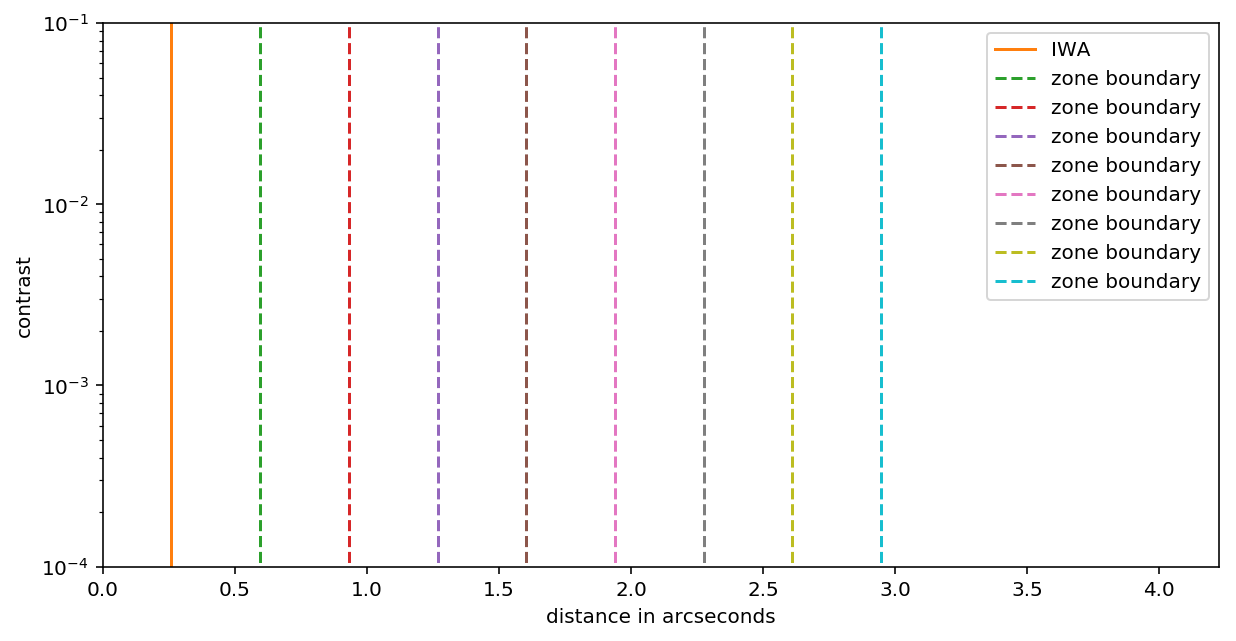

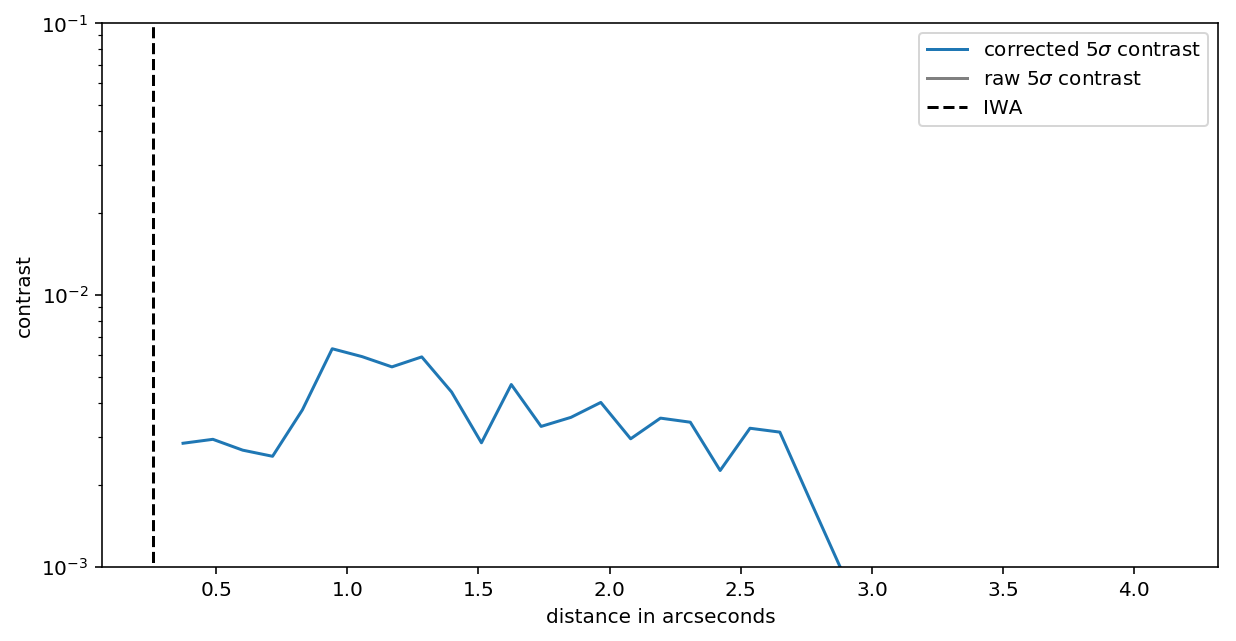

In [102]:
platescale =0.065 
imsz = dataset.input.shape[1] #Setting the image size (101)
numann = 9
annspacing = (imsz/2.-dataset.IWA)/numann #Spacing between annuli? Why need?
zone_boundaries = np.arange(1,numann)*annspacing+dataset.IWA

plt.figure(figsize = (10,5))
plt.plot(contrast_seps*platescale, contrast)
plt.plot(contrast_seps*platescale, contrast, 'bo')
plt.yscale("log")
plt.ylim(1e-4, 1e-1)
plt.xlim(0,platescale*OWA)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), label='IWA')
for bd in zone_boundaries*platescale:
    if bd<OWA*platescale:
        plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()
#plt.clf() #clear figure

#create the throughput corrected contrast curves
corrected_contrast_curve = np.copy(contrast)
for i, sep in enumerate(contrast_seps):
    closest_throughput_index = np.argmin(np.abs(planet_seps - sep))
    print('for separation', sep, " closest throughput is at separation ", planet_seps[closest_throughput_index])
    corrected_contrast_curve[i] /= throughput[closest_throughput_index]

    
plt.figure(figsize = (10,5))
plt.plot(contrast_seps*platescale, corrected_contrast_curve, label='corrected 5$\sigma$ contrast')
plt.plot(contrast_seps*platescale, contrast, label='raw 5$\sigma$ contrast', color='gray')
plt.yscale("log")
plt.ylim(1e-3, 1e-1)
plt.xlabel("distance in arcseconds")
plt.ylabel("contrast")
if dataset.IWA > 0:
    plt.plot((dataset.IWA*platescale,dataset.IWA*platescale),(1e-5,1e-1), 'k--', label='IWA')
#for bd in zone_boundaries*platescale:
 #   plt.plot((bd,bd),(0,1),'--',label='zone boundary')
plt.legend()